In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cartopy.crs as ccrs
import astropy.units as u

In [2]:
n_lats, n_lons = 20, 40
phi = np.linspace(0, 2 * np.pi, n_lons)
lat_frac = 0.9
theta = np.arcsin(np.linspace(-lat_frac, lat_frac, n_lats))
phi2d, theta2d = np.meshgrid(phi, theta)

### Structure of the Code

1. **Define the Matsuno-Gill flow pattern:** The model describes the response of a shallow-water atmosphere to an imposed heating source, capturing key features like equatorial Kelvin waves, Rossby waves, and a meridional circulation.

2. **Define the heating source:** Create a Gaussian function centered at the equator, representing the imposed heating source.

    - *Kelvin waves* are eastward-propagating atmospheric waves that are associated with the equator. They are characterized by their lack of Coriolis effect, leading to an eastward phase speed.
    
    - *Rossby waves* are westward-propagating atmospheric waves that arise due to the variation of the Coriolis effect with latitude. They are responsible for the large-scale meanders in mid-latitude weather systems.

3. **Calculate the streamfunction:** Compute the streamfunction, which is proportional to the heating source. The streamfunction is a scalar field that describes the circulation of the flow, with its gradients giving the velocity components.

    *Streamfunction equation:* Ψ = H * sin(k * φ) * sin(m * θ), where H is the heating source, k and m are the zonal and meridional wavenumbers, φ is longitude, and θ is latitude.

4. **Calculate the velocity components:** Derive the velocity components in the φ and θ directions from the streamfunction.

5. **Add an eastward jet component:** Incorporate an eastward jet component to the v_phi velocity. This is expected for Hot Jupiters due to their strong day-night temperature gradients and efficient heat redistribution, which drive the formation of strong eastward jets.

6. **Combine the velocity components:** Assemble the velocity components into a single array, and convert them into the x and y directions on the map (us and vs) for plotting.

### Key Equations

- Streamfunction: $\Psi = H \cdot \sin(k \cdot \phi) \cdot \sin(m \cdot \theta)$
- Zonal velocity (v_phi): $\frac{\partial \Psi}{\partial \theta}$
- Meridional velocity (v_theta): $-\frac{\partial \Psi}{\partial \phi}$

The streamfunction is used to describe the flow in a two-dimensional, incompressible fluid. The derivatives of the streamfunction with respect to latitude and longitude give the zonal and meridional velocities, respectively. This relationship arises because, in a 2D incompressible flow, the mass conservation equation can be simplified into a single scalar field (the streamfunction). 

The choice of the streamfunction form ($\Psi = H \cdot \sin(k \cdot \phi) \cdot \sin(m \cdot \theta)$) is inspired from the Matsuno-Gill model, which aims to capture the response of a shallow-water atmosphere to an imposed heating source. This specific form allows us to incorporate the effects of the heating source (H) and the underlying fluid dynamics, including Kelvin and Rossby waves, which are important in the context of Hot Jupiters. 

In [3]:
heating_center_lat = 0
heating_width = np.radians(15)
heating_source = norm.pdf(theta, heating_center_lat, heating_width)

In [4]:
k = 1  # Zonal wavenumber, adjust as needed
m = 1  # Meridional wavenumber, adjust as needed
heating_source_expanded = heating_source[:, np.newaxis]
streamfunction = heating_source_expanded * np.sin(k * phi2d - np.pi) * np.sin(m * theta2d)

In [5]:
delta_phi = np.gradient(phi)
delta_theta = np.gradient(theta)
v_phi = -np.gradient(streamfunction, axis=0) / delta_theta[:, np.newaxis]   # Eastward velocity
v_theta = np.gradient(streamfunction, axis=1) / delta_phi[np.newaxis, :]  # Northward velocity

In [6]:
jet_width = 15    # In degrees
jet_strength = 1  # In arbitrary units
eastward_jet = jet_strength * norm.pdf(theta, heating_center_lat, np.radians(jet_width))
v_phi += eastward_jet[:, np.newaxis]

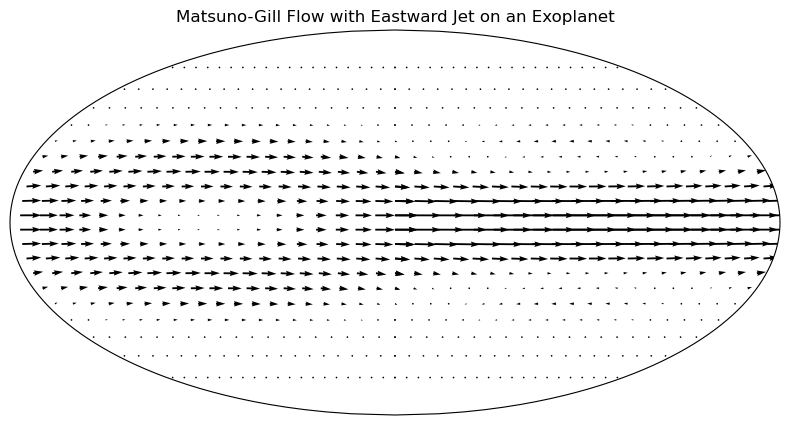

In [49]:
lats_deg = np.degrees(theta)
lons_deg = np.degrees(phi)

us = (v_phi.T * np.cos(np.radians(lats_deg))).T
vs = (v_theta.T * np.sin(np.radians(lats_deg))).T

# Something sketchy is going on in here but it's working...
zonal_mean_abs_velocity = 1000  # m/s

us_real = (us / np.max(np.abs(v_theta))) * zonal_mean_abs_velocity
vs_real = (vs / np.max(np.abs(v_phi))) * zonal_mean_abs_velocity 

Lons, Lats = np.meshgrid(lons_deg, lats_deg)

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.Mollweide()})
ax.set_global()
ax.quiver(Lons, Lats, us, vs, transform=ccrs.PlateCarree(), scale=50)
ax.set_title("Matsuno-Gill Flow with Eastward Jet on an Exoplanet")
plt.show()

In [37]:
def v_los_modified(us, vs, theta_v, phi_v, omega, R, z, lats, lons):
    '''
    This version directly assumes that the w component of the velocity field is zero.
    
    Parameters
    ----------
    us: ~numpy.array
        Zonal velocities
    vs: ~numpy.array
        Meridional velocities
    theta_v : float
        Viewing latitude
    phi_v : float
        Viewing longitude
    omega: float
        Rotation rate of the planet
    R: float
        Lower boundary of the planetary radius
    z: float
        Altitude of the velocity field 
    lats: ~numpy.array
        Latitudes from the simulation
    lons: ~numpy.array
        Longitudes from the simulation
    
    Returns
    -------
    vlos: ~numpy.array
        Line-of-sight velocities
    '''
    print(f"Original {phi_v}")
    t1   = us * np.sin(theta_v) * np.sin(lons - phi_v)
    print(np.mean(t1))
    t2   = (vs.T * np.cos(lats)).T * np.sin(theta_v) * np.cos(lons - phi_v)
    print(np.mean(t2))
    t3   = (vs.T * np.sin(lats)).T * np.cos(theta_v)
    print(np.mean(t3))
    t4   = (omega * (R * lats + z) * np.sin(lats) * np.sin(theta_v))[:, np.newaxis] * np.sin(lons - phi_v)
    print(np.mean(t4))
    vlos = t1 + t2 - t3 + t4 
    return vlos

In [128]:
def v_los_modified_generalized(velocity_fields, phi_v, theta_v, omega, R, z, lats, lons):
    '''
    This version directly assumes that the w component of the velocity field is zero.
    
    Parameters
    ----------
    velocity_fields: ~numpy.array
        Velocity fields of size (lat_bins, lon_bins, 2, n_orbital_phases), where the
        third dimension contains zonal and meridional velocities
    theta_v : float
        Viewing latitude
    omega: float
        Rotation rate of the planet
    R: float
        Lower boundary of the planetary radius
    z: float
        Altitude of the velocity field 
    lats: ~numpy.array
        Latitudes from the simulation
    lons: ~numpy.array
        Longitudes from the simulation
    
    Returns
    -------
    vlos: ~numpy.array
        Line-of-sight velocities
    '''
    us = velocity_fields[:, :, 0]
    vs = velocity_fields[:, :, 1]
    print(f"Generalized {phi_v}")
    t1 = (us * np.sin(theta_v))[...,None] * np.sin(lons[:, None] - phi_v)
    print(np.mean(t1), t1.shape)
    t2 = ((vs.T * np.cos(lats)).T * np.sin(theta_v))[...,None] * np.cos(lons[:, None] - phi_v)
    print(np.mean(t2), t2.shape)
    t3 = ((vs.T * np.sin(lats)).T * np.cos(theta_v))[...,None]
    print(np.mean(t3), t3.shape)
    t4 = (omega * (R * lats + z) * np.sin(lats) * np.sin(theta_v))[:, None, None] * np.sin(lons[:, None] - phi_v)
    print(np.mean(t4), t4.shape)
    vlos = t1 + t2 - t3 + t4 
    return vlos

Original 3.141592653589793
-126.2929478080879
4.977724028109611
-1.9721522630525296e-33
-3.865352482534945e-14
Generalized [-3.14159265]
-126.29294780808783 (20, 40, 1)
4.977724028109612 (20, 40, 1)
-1.9721522630525296e-33 (20, 40, 1)
-4.433786671143025e-14 (20, 40, 1)


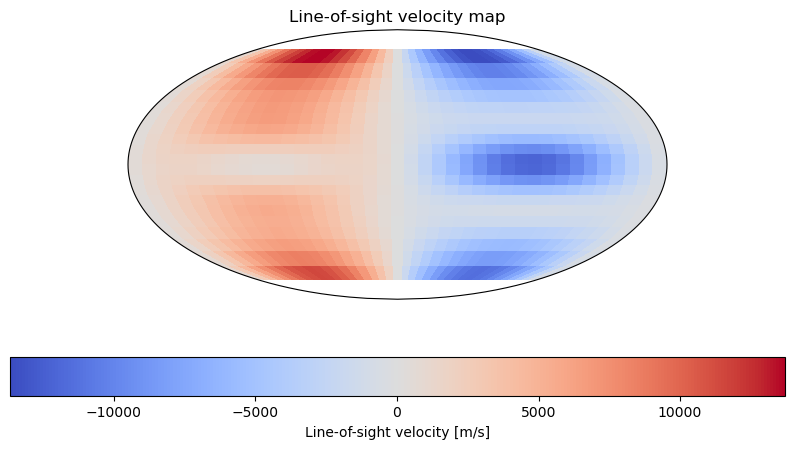

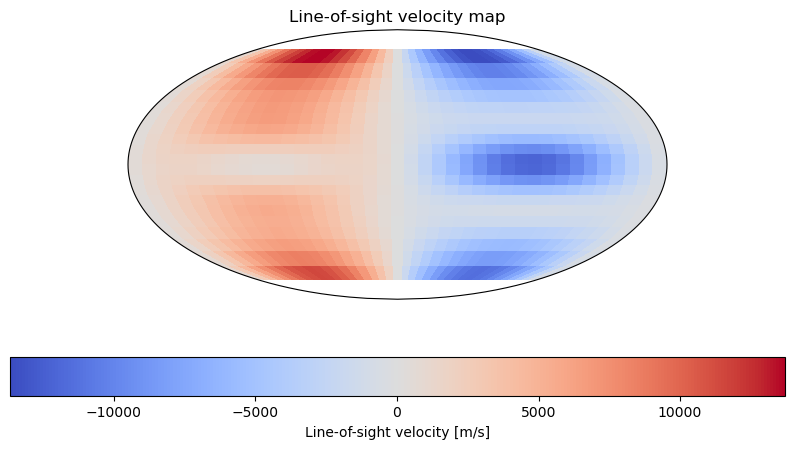

In [131]:
Rp = 1 * u.R_jup  # 1 Jupiter radius
omega = 2 * np.pi * u.rad / (10 * u.hour)  # Typical rotation rate for HJs: 10 hours period
z = 0.1 * Rp                       # Altitude: 10% of the planetary radius
theta_v = np.radians(90)           # Viewing latitude in radians
phi_v = np.radians(180)            # Viewing longitude in radians

# Convert radius and altitude to the same units (e.g., meters)
Rp = Rp.to(u.m).value
z = z.to(u.m).value

# Convert omega to the same units as other variables (e.g., rad/s)
omega = omega.to(u.rad/u.s).value

# Calculate the line-of-sight velocities using the updated parameters
vlos = v_los_modified(us_real, vs_real, theta_v, phi_v, omega, Rp, z, theta, phi)

# Broadcasting black magic to get the shape (lat_bins, lon_bins, 2, n_obs_per_orbit)
n_obs_per_orbit = 1
xi = np.array([-phi_v])
                                                                  
stacked_velocity_fields = np.stack((us_real, vs_real), axis=2)
vlos_2 = v_los_modified_generalized(stacked_velocity_fields, xi, theta_v,  omega, Rp, z, theta, phi)

# Plotting routine
Lons, Lats = np.meshgrid(lons_deg, lats_deg)
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.Mollweide()})
c = ax.pcolormesh(Lons, Lats, vlos, transform=ccrs.PlateCarree(), cmap='coolwarm', shading='auto')
ax.set_title("Line-of-sight velocity map")
ax.set_global()
fig.colorbar(c, ax=ax, orientation='horizontal', label='Line-of-sight velocity [m/s]')
plt.show()
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.Mollweide()})
c = ax.pcolormesh(Lons, Lats, vlos_2[:,:,0], transform=ccrs.PlateCarree(), cmap='coolwarm', shading='auto')
ax.set_title("Line-of-sight velocity map")
ax.set_global()
fig.colorbar(c, ax=ax, orientation='horizontal', label='Line-of-sight velocity [m/s]')
plt.show()

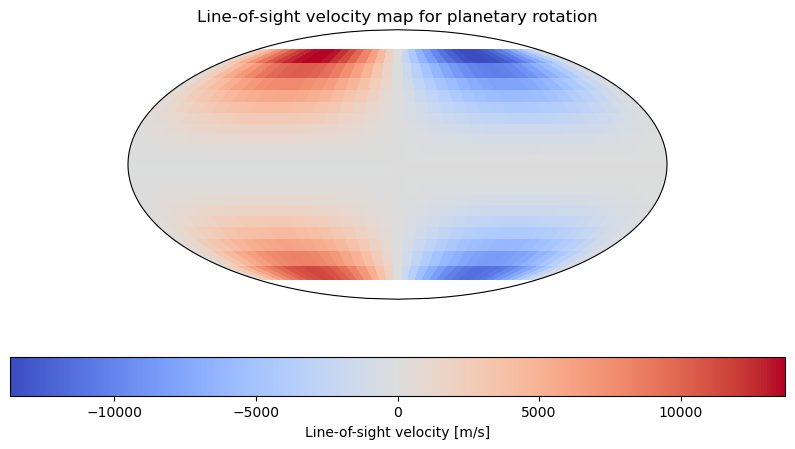

In [88]:
v_rot = (omega * (Rp * theta + z) * np.sin(theta) * np.sin(theta_v))[:, np.newaxis] * np.sin(phi - phi_v)
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.Mollweide()})
c = ax.pcolormesh(Lons, Lats, v_rot, transform=ccrs.PlateCarree(), cmap='coolwarm', shading='auto')
ax.set_title("Line-of-sight velocity map for planetary rotation")
ax.set_global()
fig.colorbar(c, ax=ax, orientation='horizontal', label='Line-of-sight velocity [m/s]')
plt.show()

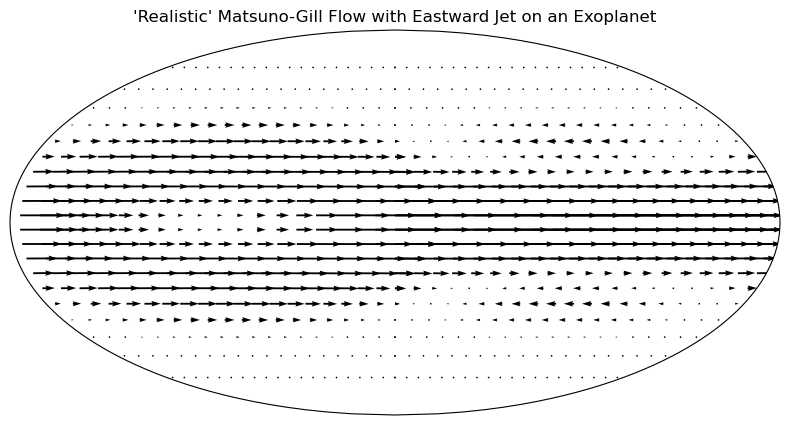

In [16]:
# Create the quiver plot with a Mollweide projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.Mollweide()})
ax.set_global()
scale_factor = 1e5  # Adjust this value to change the arrow size
ax.quiver(Lons, Lats, us_real, vs_real, transform=ccrs.PlateCarree(), scale=scale_factor)
ax.set_title("'Realistic' Matsuno-Gill Flow with Eastward Jet on an Exoplanet")
plt.show()

To generate an approximated transmission spectrum using the constructed 2D velocity maps and an underlying temperature field, we will follow these steps:

1. **Temperature field and emission flux**: Assume we know the underlying temperature field and the resulting emission flux.
2. **Doppler shift of wavelengths**: Calculate the Doppler shift of wavelengths using the line-of-sight velocities ($v_{LOS}$): 
    $$\lambda_{eff} = \lambda_0 \left( 1 - \frac{v_{LOS}}{c} \right)$$
3. **Opacity data**: Read in the opacities of a given set of molecules. For simplicity, let's start with a single molecule.
4. **Doppler-shifted opacities**: The Doppler-shifted wavelengths will affect the opacities of the molecules.
5. **Approximate transmission spectrum**: Calculate the transit radii, i.e., the approximate transmission spectrum using the formula from Heng & Kitzmann (2017):
    $$R = R_0 + H \left[ \gamma + \ln \left( \frac{P_0 \kappa}{g} \sqrt{\frac{2 \pi R_0}{H}}\right)\right]$$
6. **Visibility weighting**: For each binned point on the 2D sphere, weigh the contributions according to the visibility of the point based on its position during the transit.
7. **Generate the spectrum**: Combine the contributions from each visible point to generate the final transmission spectrum.

This approach combines the 2D velocity maps, temperature field, and molecular opacities to estimate the transmission spectrum of an exoplanet's atmosphere.
